<img src="https://github.com/rjpost20/Anomalous-Bank-Transactions-Detection-Project/blob/main/data/AdobeStock_319163865.jpeg?raw=true">
Image by <a href="https://stock.adobe.com/contributor/200768506/andsus?load_type=author&prev_url=detail" >AndSus</a> on Adobe Stock

# Phase 5 Project: *Detecting Anomalous Financial Transactions*

## Notebook 3: Modeling, Analysis and Results

### By Ryan Posternak

Flatiron School, Full-Time Live NYC<br>
Project Presentation Date: August 25th, 2022<br>
Instructor: Joseph Mata

<br>

# Imports and Reading in Data

### Google colab compatibility downloads

In [1]:
!sudo apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.3.0/spark-3.3.0-bin-hadoop3.tgz 
!tar xf spark-3.3.0-bin-hadoop3.tgz
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.0-bin-hadoop3"
!pip install pyspark==3.3.0
!pip install -q findspark
import findspark
findspark.init()

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:5 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Hit:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:11 http://security.ubuntu.com/ubuntu bionic-security/universe amd64 Packages [1,533 kB]
Get:12 http://security.ubuntu.com/ubuntu bionic-security/main amd64 Packages 

In [2]:
# Connect to Google drive
from google.colab import drive, files
drive.mount('/content/drive')
drive_path = '/content/drive/MyDrive/Colab Notebooks/'

Mounted at /content/drive


In [3]:
import numpy as np

from pyspark.sql import SparkSession
import pyspark.sql.functions as F

from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.classification import LogisticRegression, LinearSVC, NaiveBayes, \
DecisionTreeClassifier, GBTClassifier, RandomForestClassifier, MultilayerPerceptronClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit, TrainValidationSplitModel

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
from IPython.display import HTML, display
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [4]:
# Import helper functions
helper_functions = files.upload()
from helper_functions import set_weight_col

Saving helper_functions.py to helper_functions.py


In [5]:
# Check Colab GPU info
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
else:
    print(gpu_info)

Not connected to a GPU


In [6]:
# Check Colab RAM info
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [7]:
# Set text to wrap in Google colab notebook
def set_css():
    display(HTML("""
    <style>
      pre {
          white-space: pre-wrap;
      }
    </style>
    """))
get_ipython().events.register('pre_run_cell', set_css)

In [8]:
# Initialize Spark Session
spark = SparkSession.builder\
        .master("local[*]")\
        .appName("Colab")\
        .config("spark.ui.port", "4050")\
        .config("spark.driver.memory", "15g")\
        .getOrCreate()

spark

## Read in Data

In [9]:
# Read in weighted_df and resampled_df (training data) and test_df_numeric (testing data) data csv files as Spark DataFrames
train_df_numeric = spark.read.csv(drive_path + 'train_df_numeric.csv', header=True, inferSchema=True)
test_df_numeric = spark.read.csv(drive_path + 'test_df_numeric.csv', header=True, inferSchema=True)

<br>

## Add `Weight` column to dataframe

As we've seen, the training dataset is extremely imbalanced in regards to target class distribution. In order to improve modeling performance, we'll add a new column `Weight` to `train_df_numeric` specifying the weights to use, which we pass in to PySpark models in the `weightCol` parameter. We'll create the new `Weight` column using the `set_weight_col` function in `helper_functions`.

Our initial `Weight` column will specify equal weights across all observations, which is the default in PySpark.

In [10]:
print(set_weight_col.__doc__)


    Calculates and creates a column of class weights 
    in a PySpark dataframe with an imbalanced binary 
    target class distribution.

    Parameters
    ----------
    df : Spark `DataFrame`
        The Spark `DataFrame` to assign the 
        `ClassWeight` column to
    label_col : Spark `Column`
        Label column name
    neg_class_weight : '`float` or 'balanced'
        New class weight to assign to negative class 
        (`0`) in weight column. If 'balanced', assigned 
        class weights will be equal to 1 - proportion of 
        class in dataframe. If `float`, negative class 
        will be assigned `neg_class_weight` and positive 
        class weights remain at 1.0.
    


In [11]:
train_df_numeric = set_weight_col(train_df_numeric, label_col='Label', neg_class_weight=1.0)

In [12]:
# Preview Weight column
cols_to_show = ['MessageId', 'Label', 'Weight']
train_df_numeric.select(cols_to_show).where(train_df_numeric.Label == 0).show(1, truncate=False, vertical=True)
train_df_numeric.select(cols_to_show).where(train_df_numeric.Label == 1).show(1, truncate=False, vertical=True)

-RECORD 0---------------
 MessageId | TRFXV1O7R2 
 Label     | 0          
 Weight    | 1.0        
only showing top 1 row

-RECORD 0---------------
 MessageId | TR14I40JIT 
 Label     | 1          
 Weight    | 1.0        
only showing top 1 row



In [13]:
# Print shape of dataframes
print(f"train_df_numeric:  {train_df_numeric.count():,} Rows, {len(train_df_numeric.columns)} Columns")
print(f"test_df_numeric:  {test_df_numeric.count():,} Rows, {len(test_df_numeric.columns)} Columns")

train_df_numeric:  4,691,725 Rows, 15 Columns
test_df_numeric:  705,108 Rows, 14 Columns


In [14]:
# Print schema of training dataframe
print('train_df_numeric:')
train_df_numeric.printSchema()

train_df_numeric:
root
 |-- MessageId: string (nullable = true)
 |-- Label: integer (nullable = true)
 |-- InstructedAmountUSD: integer (nullable = true)
 |-- IntermediaryTransactions: integer (nullable = true)
 |-- Flagged: integer (nullable = true)
 |-- OrderingCountryFreq: integer (nullable = true)
 |-- BeneficiaryCountryFreq: integer (nullable = true)
 |-- Hour: integer (nullable = true)
 |-- SenderHourFreq: integer (nullable = true)
 |-- SenderCurrencyFreq: integer (nullable = true)
 |-- SenderCurrencyAmtAvg: integer (nullable = true)
 |-- SenderFreq: integer (nullable = true)
 |-- ReceiverFreq: integer (nullable = true)
 |-- SenderReceiverFreq: integer (nullable = true)
 |-- Weight: double (nullable = true)



In [15]:
# Print schema of test dataframe
print('test_df_numeric:')
test_df_numeric.printSchema()

test_df_numeric:
root
 |-- MessageId: string (nullable = true)
 |-- Label: integer (nullable = true)
 |-- InstructedAmountUSD: integer (nullable = true)
 |-- IntermediaryTransactions: integer (nullable = true)
 |-- Flagged: integer (nullable = true)
 |-- OrderingCountryFreq: integer (nullable = true)
 |-- BeneficiaryCountryFreq: integer (nullable = true)
 |-- Hour: integer (nullable = true)
 |-- SenderHourFreq: integer (nullable = true)
 |-- SenderCurrencyFreq: integer (nullable = true)
 |-- SenderCurrencyAmtAvg: integer (nullable = true)
 |-- SenderFreq: integer (nullable = true)
 |-- ReceiverFreq: integer (nullable = true)
 |-- SenderReceiverFreq: integer (nullable = true)



In [16]:
# Drop 'MessageId' individual transaction identifier column - will not be used in modeling
train_df_numeric = train_df_numeric.drop('MessageId')
test_df_numeric = test_df_numeric.drop('MessageId')

# Rename target variable 'Label' column to more descriptive 'Anomalous'
train_df_numeric = train_df_numeric.withColumnRenamed('Label', 'Anomalous')
test_df_numeric = test_df_numeric.withColumnRenamed('Label', 'Anomalous')

In [17]:
# Display first row of train_df_numeric dataframe
train_df_numeric.show(n=1, truncate=False, vertical=True)

-RECORD 0---------------------------
 Anomalous                | 0       
 InstructedAmountUSD      | 519149  
 IntermediaryTransactions | 0       
 Flagged                  | 0       
 OrderingCountryFreq      | 73733   
 BeneficiaryCountryFreq   | 40984   
 Hour                     | 8       
 SenderHourFreq           | 47559   
 SenderCurrencyFreq       | 73733   
 SenderCurrencyAmtAvg     | 1906631 
 SenderFreq               | 73733   
 ReceiverFreq             | 41012   
 SenderReceiverFreq       | 40984   
 Weight                   | 1.0     
only showing top 1 row



In [18]:
# Display first row of test_df_numeric dataframe
test_df_numeric.show(n=1, truncate=False, vertical=True)

-RECORD 0---------------------------
 Anomalous                | 0       
 InstructedAmountUSD      | 653958  
 IntermediaryTransactions | 0       
 Flagged                  | 0       
 OrderingCountryFreq      | 73733   
 BeneficiaryCountryFreq   | 40984   
 Hour                     | 8       
 SenderHourFreq           | 47559   
 SenderCurrencyFreq       | 73733   
 SenderCurrencyAmtAvg     | 1906631 
 SenderFreq               | 73733   
 ReceiverFreq             | 41012   
 SenderReceiverFreq       | 40984   
only showing top 1 row



In [19]:
# Display value counts for 'Anomalous' column (classification target)
class_counts = train_df_numeric.groupBy('Anomalous').count().withColumn('percent', F.col('count')/train_df_numeric.count())

class_counts.show(truncate=False)

+---------+-------+---------------------+
|Anomalous|count  |percent              |
+---------+-------+---------------------+
|1        |4900   |0.0010443919880214632|
|0        |4686825|0.9989556080119786   |
+---------+-------+---------------------+



<br>

# Create Pipeline to Preprocess and Model Data

### Index string columns with StringIndexer

In [ ]:
# stages = []

# categoricalCols = [item[0] for item in train_df_resampled.dtypes if item[1].startswith('string')]

# indexers = []

# for col in categoricalCols:
#     indexer = StringIndexer(inputCol=col, outputCol=col + '_index', handleInvalid='keep')
#     indexers.append(indexer)
    
# indexed_features = []
# for si in indexers:
#     indexed_features.append(si.getOutputCol())
    
# print(f"Indexed nominal categorical features: \n{indexed_features}")

### Create a OneHotEncoder to encode the indexed string features

In [ ]:
# encoder = OneHotEncoder(inputCols=indexed_features, 
#                         outputCols=[col + '_ohe' for col in indexed_features], 
#                         dropLast=True)

# print(f"One hot encoded nominal categorical features: {len(encoder.getOutputCols())}\n{encoder.getOutputCols()}")

### Compile numeric features, not including target or class weight columns

In [20]:
numeric_features = []
for column in train_df_numeric.columns:
    if column != 'Anomalous' and column != 'Weight':
        numeric_features.append(column)

# Confirm equal column counts
assert len(train_df_numeric.drop('Anomalous', 'Weight').columns) == len(numeric_features)
print(f"Numeric features: {len(numeric_features)}\n{numeric_features}")

Numeric features: 12
['InstructedAmountUSD', 'IntermediaryTransactions', 'Flagged', 'OrderingCountryFreq', 'BeneficiaryCountryFreq', 'Hour', 'SenderHourFreq', 'SenderCurrencyFreq', 'SenderCurrencyAmtAvg', 'SenderFreq', 'ReceiverFreq', 'SenderReceiverFreq']


In [21]:
# Print names of final features going into the model
features = numeric_features
print(f"Final features: {len(features)}\n{features}")

Final features: 12
['InstructedAmountUSD', 'IntermediaryTransactions', 'Flagged', 'OrderingCountryFreq', 'BeneficiaryCountryFreq', 'Hour', 'SenderHourFreq', 'SenderCurrencyFreq', 'SenderCurrencyAmtAvg', 'SenderFreq', 'ReceiverFreq', 'SenderReceiverFreq']


### Create a VectorAssembler to combine all features

In [22]:
assembler = VectorAssembler(inputCols=features, outputCol='vectorized_features')

# Assemble a list of stages that includes the vector assembler and standard scaler
scaler = StandardScaler(inputCol='vectorized_features', outputCol='scaled_features')

stages = [assembler, scaler]
print("Stages:", stages)

Stages: [VectorAssembler_fc047c88778b, StandardScaler_125a9a14e2f5]


### Preview modeling pipeline

In [23]:
pipeline = Pipeline(stages=stages)

pipeline_model = pipeline.fit(train_df_numeric)

pipeline_df = pipeline_model.transform(train_df_numeric)

In [24]:
# Display first row of train_df_numeric after running through pipeline
pipeline_df.show(1, vertical=True, truncate=False)

-RECORD 0--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Anomalous                | 0                                                                                                                                                                                                                  
 InstructedAmountUSD      | 519149                                                                                                                                                                                                             
 IntermediaryTransactions | 0                                                                                                                                                                                                                  
 Flagged                  | 0           

In [25]:
pipeline_test = pipeline.fit(test_df_numeric)

pipeline_df_test = pipeline_model.transform(test_df_numeric)

pipeline.fit(test_df_numeric).transform(test_df_numeric).head()['scaled_features'].size

12

In [26]:
# Display first row of test_df_numeric after running through pipeline
pipeline_df_test.show(1, vertical=True, truncate=False)

-RECORD 0--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Anomalous                | 0                                                                                                                                                                                                                  
 InstructedAmountUSD      | 653958                                                                                                                                                                                                             
 IntermediaryTransactions | 0                                                                                                                                                                                                                  
 Flagged                  | 0           

<br>

In [27]:
def grid_search(stages_with_classifier, train_df, model_grid, parallelism, seed=42):
    pipeline = Pipeline(stages=stages_with_classifier)
    # Define evaluator
    evaluator = BinaryClassificationEvaluator(labelCol='Anomalous', 
                                              metricName="areaUnderPR")
    # Define train/validation split with pipeline above
    tvs = TrainValidationSplit(estimator=pipeline, 
                               estimatorParamMaps=model_grid, 
                               evaluator=evaluator, 
                               parallelism=parallelism, 
                               seed=seed)
    # Fit the tvs model
    tvs_model = tvs.fit(train_df)
    # Store best model parameters in variable
    best_model_parameters = model_grid[np.argmax(tvs_model.validationMetrics)]

    # Print best model parameters
    print(best_model_parameters)
    # Return best model
    return tvs_model

In [28]:
def score_model(model, train_df, test_df):
    # Print model name
    try:
        print(str(model.bestModel.stages[-1]).split(':')[0])
        length = len(str(model.bestModel.stages[-1]).split(':')[0])
    except AttributeError:
        print(str(model.stages[-1]).split(':')[0])
        length = len(str(model.stages[-1]).split(':')[0])
    print('-'*length, '\n')

    # Predict on training and testing data
    train_pred = model.transform(train_df)
    test_pred = model.transform(test_df)

    # Convert target class columns to NumPy arrays for Sklearn
    y_true_train = np.array(train_pred.select('Anomalous').collect())
    y_true_test = np.array(test_pred.select('Anomalous').collect())

    # Convert prediction columns to NumPy arrays for Sklearn
    y_predicted_train = np.array(train_pred.select('prediction').collect())
    y_predicted_test = np.array(test_pred.select('prediction').collect())

    target_names = ['0: Non-anomalous', '1: Anomalous']
    # Print training set classification report
    print('Training data:\n')
    print(classification_report(y_true_train, 
                                y_predicted_train, 
                                target_names=target_names, 
                                digits=3))
    print('-'*60, '\n')
    # Print test set classification report
    print('Testing data:\n')
    print(classification_report(y_true_test, 
                                y_predicted_test, 
                                target_names=target_names, 
                                digits=3))

In [30]:
def plot_confusion_matrix(model, test_df, preprocessing_stages=stages):
    # Convert Anomalous column to array
    y_true = np.array(test_df.select('Anomalous').collect())
    # Calculate predictions and convert prediction column to array
    y_predicted = np.array(model.transform(test_df).select('prediction').collect())

    
    fig, ax1 = plt.subplots(figsize=(18, 7))

    # Plot confusion matrix
    labels = ['0: Non-anomalous', '1: Anomalous']
    cm = confusion_matrix(y_true, y_predicted)
    cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    cm_disp.plot(cmap='Reds', ax=ax1, values_format='')
    ax1.set_title('Confusion Matrix - Test Data', size=15, fontweight='bold')
    ax1.set_xlabel(ax1.get_xlabel(), size=13)
    ax1.set_ylabel(ax1.get_ylabel(), size=13)
    ax1.tick_params(axis='both', which='both', labelsize=12)
    for labels in cm_disp.text_.ravel():
        labels.set_fontsize(12)
    ax1.grid(False)

<br>

# **Baseline Model**: Basic Logistic Regression

For our first and baseline model, we'll fit a simple un-tuned logistic regression model.

In [31]:
# Set classifier parameters
lr_0 = LogisticRegression(
    featuresCol='scaled_features',
    labelCol='Anomalous',
    weightCol='Weight',
    standardization=False)

In [32]:
# Assign to pipeline
lr_0_pipeline = Pipeline(stages=stages + [lr_0])

# Fit to training data
if not os.path.isdir(drive_path + 'lr_0_model'):
    lr_0_model = lr_0_pipeline.fit(train_df_numeric)

In [33]:
# Save model, or upload if already saved
if not os.path.isdir(drive_path + 'lr_0_model'):
    lr_0_model.save(drive_path + 'lr_0_model')
else:
    lr_0_model = PipelineModel.load(drive_path + 'lr_0_model')

In [34]:
# Print model scores
score_model(model=lr_0_model, train_df=train_df_numeric, test_df=test_df_numeric)

LogisticRegressionModel
----------------------- 

Training data:

                  precision    recall  f1-score   support

0: Non-anomalous      0.999     1.000     1.000   4686825
    1: Anomalous      1.000     0.317     0.482      4900

        accuracy                          0.999   4691725
       macro avg      1.000     0.659     0.741   4691725
    weighted avg      0.999     0.999     0.999   4691725

------------------------------------------------------------ 

Testing data:

                  precision    recall  f1-score   support

0: Non-anomalous      0.999     0.968     0.983    704347
    1: Anomalous      0.010     0.294     0.019       761

        accuracy                          0.967    705108
       macro avg      0.504     0.631     0.501    705108
    weighted avg      0.998     0.967     0.982    705108



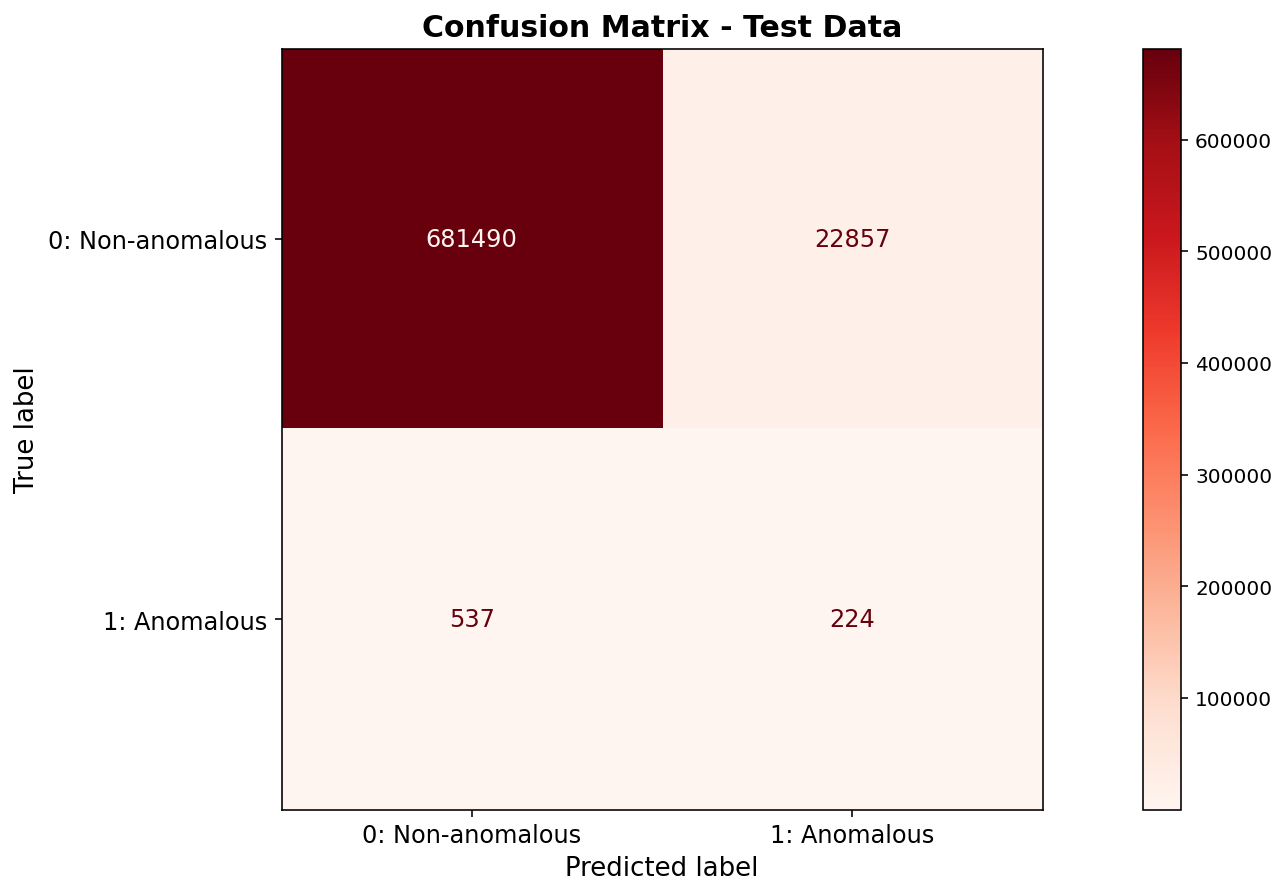

In [35]:
# Plot model confusion matrix
plot_confusion_matrix(model=lr_0_model, test_df=test_df_numeric)

**Remarks:**
- With a test set F1-score of only 0.019 and nearly 23k false positives, we're not doing too well on the testing data. It looks like we're overfitting to the training data since the F1-score is significantly better on the training data. We'll try to address that in the next model.

<br>

# Model 1.1: **Logistic Regression** with Tuned Regularization

For our first tuned `LogisticRegression` model, we'll try to address the overfitting by using regularization.

The `elasticNetParam` hyperparameter specifies the ElasticNet mixing parameter - 0 = L2, while 1 = L1.<br>
The `regParam` hyperparameter specifies the regularization strength.

In [36]:
lr_1 = LogisticRegression(
    featuresCol='scaled_features',
    labelCol='Anomalous',
    weightCol='Weight',
    standardization=False)

lr_1_stages = stages + [lr_1]

# Specify parameter grid
lr_1_grid = ParamGridBuilder()\
            .addGrid(lr_1.elasticNetParam, [0, 0.25, 0.5, 0.75, 1.0])\
            .addGrid(lr_1.regParam, [0.001, 0.005, 0.01])\
            .build()

In [37]:
# Run grid search
if not os.path.isdir(drive_path + 'lr_1_model'):
    lr_1_model = grid_search(stages_with_classifier=lr_1_stages, 
                             train_df=train_df_numeric, 
                             model_grid=lr_1_grid, 
                             parallelism=5)

In [38]:
# Save model, or upload if already saved
if not os.path.isdir(drive_path + 'lr_1_model'):
    lr_1_model.save(drive_path + 'lr_1_model')
else:
    lr_1_model = TrainValidationSplitModel.load(drive_path + 'lr_1_model')
    print(lr_1_grid[np.argmax(lr_1_model.validationMetrics)])

{Param(parent='LogisticRegression_445468544896', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.25, Param(parent='LogisticRegression_445468544896', name='regParam', doc='regularization parameter (>= 0).'): 0.005}


In [39]:
# Print model scores
score_model(lr_1_model, train_df_numeric, test_df_numeric)

LogisticRegressionModel
----------------------- 

Training data:

                  precision    recall  f1-score   support

0: Non-anomalous      0.999     1.000     1.000   4686825
    1: Anomalous      1.000     0.186     0.314      4900

        accuracy                          0.999   4691725
       macro avg      1.000     0.593     0.657   4691725
    weighted avg      0.999     0.999     0.999   4691725

------------------------------------------------------------ 

Testing data:

                  precision    recall  f1-score   support

0: Non-anomalous      0.999     1.000     1.000    704347
    1: Anomalous      1.000     0.152     0.265       761

        accuracy                          0.999    705108
       macro avg      1.000     0.576     0.632    705108
    weighted avg      0.999     0.999     0.999    705108



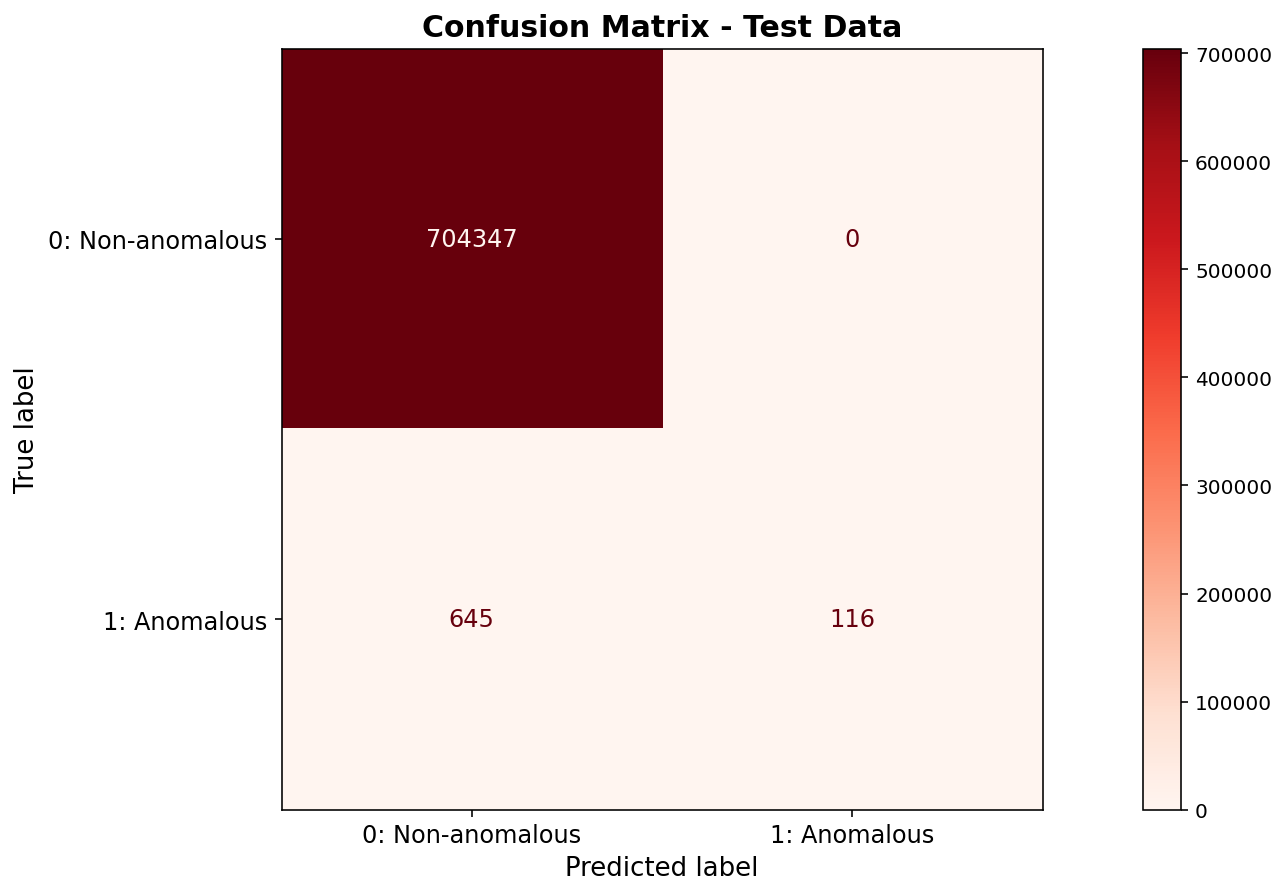

In [40]:
# Plot model confusion matrix
plot_confusion_matrix(lr_1_model, test_df_numeric)

**Remarks:**
- Applying regularization improved the model tremendously! We had nearly 23k false positives with the baseline model, and now we don't have a single one. Our test set recall decreased a bit, from 0.294 to 0.152, but for perfect precision I'll take that any day. Our test set F1-score is now 0.265.

<br>

# Model 1.2: **Logistic Regression** with Tuned Threshold and Max Iterations

For our next tuned model, we'll attempt to optimize the logistic regression classification threshold and the maximum number of iterations. Since we didn't have a single false positive in the last model, we might be able to bring the threshold down and/or increase the iterations without incurring too much of a hit to the false positive rate, resulting in a higher overall F1-score.

In [41]:
lr_2 = LogisticRegression(
    featuresCol='scaled_features',
    labelCol='Anomalous',
    weightCol='Weight',
    standardization=False, 
    elasticNetParam=0.25, 
    regParam=0.005)

lr_2_stages = stages + [lr_2]

# Specify parameter grid
lr_2_grid = ParamGridBuilder()\
            .addGrid(lr_2.threshold, [0.25, 0.325, 0.4])\
            .addGrid(lr_2.maxIter, [100, 150, 200])\
            .build()

In [42]:
# Run grid search using grid_search function
if not os.path.isdir(drive_path + 'lr_2_model'):
    lr_2_model = grid_search(stages_with_classifier=lr_2_stages, 
                             train_df=train_df_numeric, 
                             model_grid=lr_2_grid, 
                             parallelism=5)

In [43]:
# Save model, or upload if already saved
if not os.path.isdir(drive_path + 'lr_2_model'):
    lr_2_model.save(drive_path + 'lr_2_model')
else:
    lr_2_model = TrainValidationSplitModel.load(drive_path + 'lr_2_model')
    print(lr_2_grid[np.argmax(lr_2_model.validationMetrics)])

{Param(parent='LogisticRegression_5e7e4fa932e3', name='threshold', doc='Threshold in binary classification prediction, in range [0, 1]. If threshold and thresholds are both set, they must match.e.g. if threshold is p, then thresholds must be equal to [1-p, p].'): 0.25, Param(parent='LogisticRegression_5e7e4fa932e3', name='maxIter', doc='max number of iterations (>= 0).'): 100}


In [44]:
# Print model scores
score_model(lr_2_model, train_df_numeric, test_df_numeric)

LogisticRegressionModel
----------------------- 

Training data:

                  precision    recall  f1-score   support

0: Non-anomalous      0.999     1.000     1.000   4686825
    1: Anomalous      1.000     0.186     0.314      4900

        accuracy                          0.999   4691725
       macro avg      1.000     0.593     0.657   4691725
    weighted avg      0.999     0.999     0.999   4691725

------------------------------------------------------------ 

Testing data:

                  precision    recall  f1-score   support

0: Non-anomalous      0.999     1.000     1.000    704347
    1: Anomalous      1.000     0.152     0.265       761

        accuracy                          0.999    705108
       macro avg      1.000     0.576     0.632    705108
    weighted avg      0.999     0.999     0.999    705108



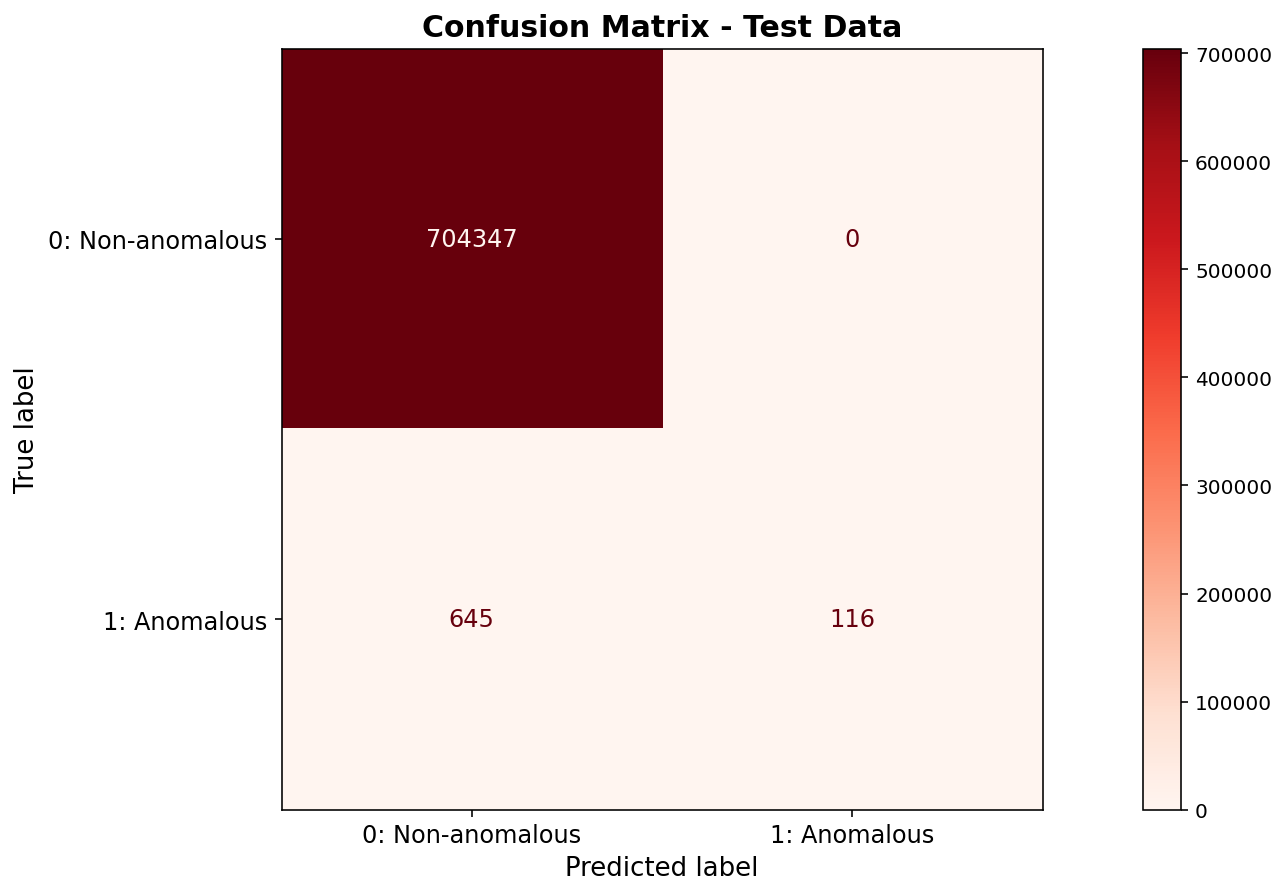

In [45]:
# Plot model confusion matrix
plot_confusion_matrix(lr_2_model, test_df_numeric)

**Remarks:**
- Even after reducing the threshold to 0.25, our results didn't budge an inch on the testing data. We're getting 100% precision with anomalous transactions but only 15.2% recall.
- What is probably occurring, now that we're applying regularization, is that the model is looking at the `Flagged` feature and seeing that it is such a good predictor (perfect in fact), that it's "reasoning" that it can get a pretty good AUPRC score with just that feature and reducing the weights of the other features. Those 116 correctly classified anomalous features are likely the ones that are flagged. Let's move on to another model type.

<br>

# Model 2.1: **Support Vector Classifier** with Adjusted Weights and Tuned Max Iterations

For our first support vector classifier, we'll try tinkering with the weights assigned to the classes. We'll adjust the negative class weight to 0.1, meaning we reduce the "importance" of negative target class observations by a factor of 10.

We'll also grid search over this newly weighted dataset with adjusted max iterations.

In [46]:
train_df_numeric = set_weight_col(train_df_numeric, label_col='Anomalous', neg_class_weight=0.1)

# Preview Weight column
cols_to_show = ['Anomalous', 'Weight']
train_df_numeric.select(cols_to_show).where(train_df_numeric.Anomalous == 0).show(1, truncate=False, vertical=True)
train_df_numeric.select(cols_to_show).where(train_df_numeric.Anomalous == 1).show(1, truncate=False, vertical=True)

-RECORD 0--------
 Anomalous | 0   
 Weight    | 0.1 
only showing top 1 row

-RECORD 0--------
 Anomalous | 1   
 Weight    | 1.0 
only showing top 1 row



In [47]:
svc_1 = LinearSVC(
    featuresCol='scaled_features',
    labelCol='Anomalous',
    weightCol='Weight',
    standardization=False)

svc_1_stages = stages + [svc_1]

# Specify parameter grid
svc_1_grid = ParamGridBuilder()\
            .addGrid(svc_1.maxIter, [100, 150, 200])\
            .build()

In [48]:
# Run grid search using grid_search function
%%time
if not os.path.isdir(drive_path + 'svc_1_model'):
    svc_1_model = grid_search(stages_with_classifier=svc_1_stages, 
                              train_df=train_df_numeric, 
                              model_grid=svc_1_grid, 
                              parallelism=3)

CPU times: user 513 µs, sys: 20 µs, total: 533 µs
Wall time: 486 µs


In [49]:
# Save model, or upload if already saved
if not os.path.isdir(drive_path + 'svc_1_model'):
    svc_1_model.save(drive_path + 'svc_1_model')
else:
    svc_1_model = TrainValidationSplitModel.load(drive_path + 'svc_1_model')
    print(svc_1_grid[np.argmax(svc_1_model.validationMetrics)])

{Param(parent='LinearSVC_76bfca614b1b', name='maxIter', doc='max number of iterations (>= 0).'): 100}


In [50]:
# Print model scores
score_model(svc_1_model, train_df_numeric, test_df_numeric)

LinearSVCModel
-------------- 

Training data:

                  precision    recall  f1-score   support

0: Non-anomalous      0.999     1.000     1.000   4686825
    1: Anomalous      1.000     0.186     0.314      4900

        accuracy                          0.999   4691725
       macro avg      1.000     0.593     0.657   4691725
    weighted avg      0.999     0.999     0.999   4691725

------------------------------------------------------------ 

Testing data:

                  precision    recall  f1-score   support

0: Non-anomalous      0.999     1.000     1.000    704347
    1: Anomalous      1.000     0.152     0.265       761

        accuracy                          0.999    705108
       macro avg      1.000     0.576     0.632    705108
    weighted avg      0.999     0.999     0.999    705108



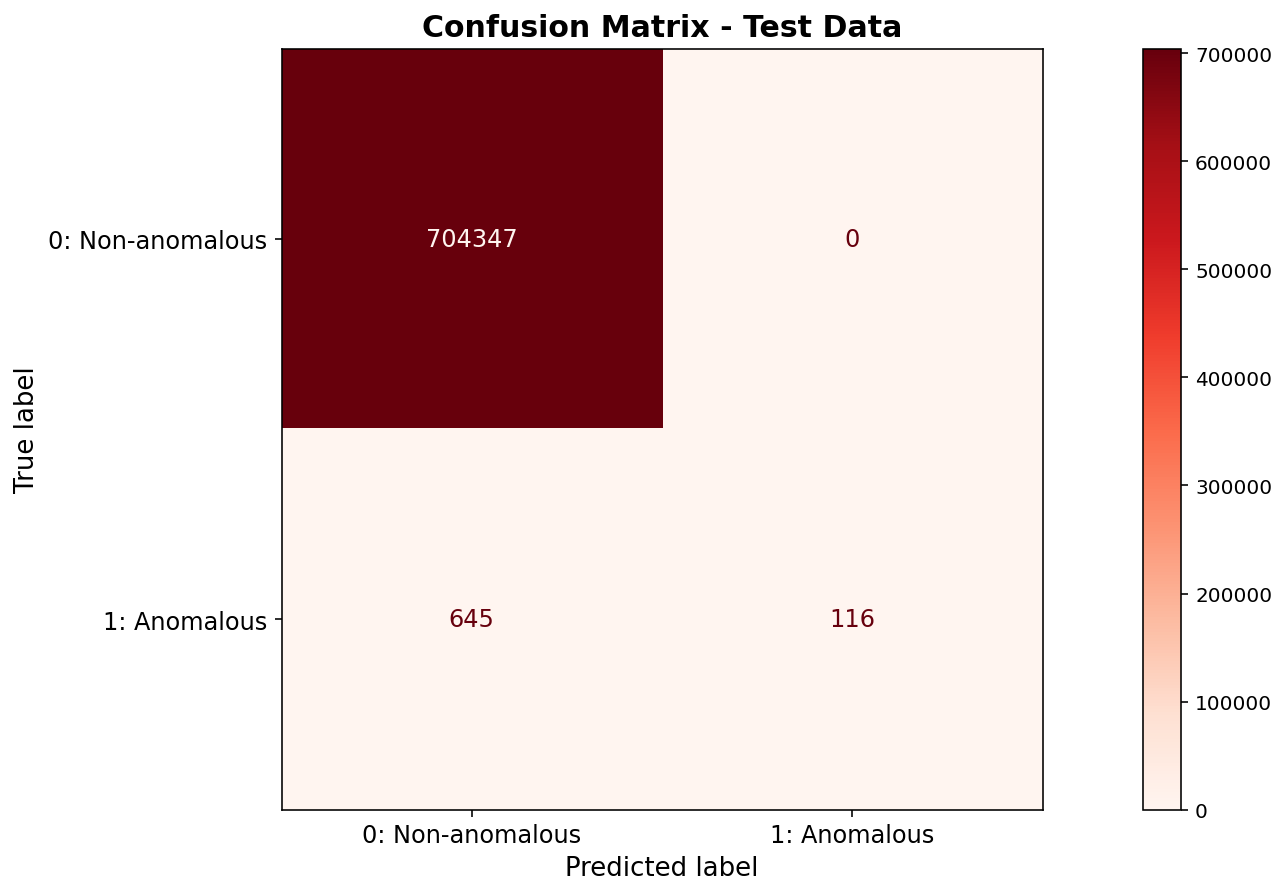

In [51]:
# Plot model confusion matrix
plot_confusion_matrix(svc_1_model, test_df_numeric)

**Remarks:**
- It looks like the SVC model is doing the same thing the last logistic regression model is doing. Let's try adjusting the threshold down a bit to see if we can do a bit better on the recall score with anomalous transactions.

<br>

# Model 2.2: **Support Vector Classifier** with Tuned Threshold

On the previous three models we've been getting perfect precision, but we're stuck at a mediocre 15.2% recall. We'll now return to the classification threshold hyperparameter to see if we can raise the recall score to achieve a better F1-score. We'll also raise the negative class weight a bit to 0.5.

In [52]:
train_df_numeric = set_weight_col(train_df_numeric, label_col='Anomalous', neg_class_weight=0.5)

# Preview Weight column
cols_to_show = ['Anomalous', 'Weight']
train_df_numeric.select(cols_to_show).where(train_df_numeric.Anomalous == 0).show(1, truncate=False, vertical=True)
train_df_numeric.select(cols_to_show).where(train_df_numeric.Anomalous == 1).show(1, truncate=False, vertical=True)

-RECORD 0--------
 Anomalous | 0   
 Weight    | 0.5 
only showing top 1 row

-RECORD 0--------
 Anomalous | 1   
 Weight    | 1.0 
only showing top 1 row



In [53]:
svc_2 = LinearSVC(
    featuresCol='scaled_features',
    labelCol='Anomalous',
    weightCol='Weight',
    standardization=False)

svc_2_stages = stages + [svc_2]

# Specify parameter grid
svc_2_grid = ParamGridBuilder()\
            .addGrid(svc_2.threshold, [0.05, 0.1, 0.15, 0.2])\
            .build()

In [54]:
# Run grid search using grid_search function
if not os.path.isdir(drive_path + 'svc_2_model'):
    svc_2_model = grid_search(stages_with_classifier=svc_2_stages, 
                              train_df=train_df_numeric, 
                              model_grid=svc_2_grid, 
                              parallelism=4)

In [55]:
# Save model, or upload if already saved
if not os.path.isdir(drive_path + 'svc_2_model'):
    svc_2_model.save(drive_path + 'svc_2_model')
else:
    svc_2_model = TrainValidationSplitModel.load(drive_path + 'svc_2_model')
    print(svc_2_grid[np.argmax(svc_2_model.validationMetrics)])

{Param(parent='LinearSVC_d773c76989f2', name='threshold', doc='The threshold in binary classification applied to the linear model prediction.  This threshold can be any real number, where Inf will make all predictions 0.0 and -Inf will make all predictions 1.0.'): 0.05}


In [56]:
# Print model scores
score_model(svc_2_model, train_df_numeric, test_df_numeric)

LinearSVCModel
-------------- 

Training data:

                  precision    recall  f1-score   support

0: Non-anomalous      0.999     1.000     1.000   4686825
    1: Anomalous      1.000     0.186     0.314      4900

        accuracy                          0.999   4691725
       macro avg      1.000     0.593     0.657   4691725
    weighted avg      0.999     0.999     0.999   4691725

------------------------------------------------------------ 

Testing data:

                  precision    recall  f1-score   support

0: Non-anomalous      0.999     1.000     1.000    704347
    1: Anomalous      1.000     0.152     0.265       761

        accuracy                          0.999    705108
       macro avg      1.000     0.576     0.632    705108
    weighted avg      0.999     0.999     0.999    705108



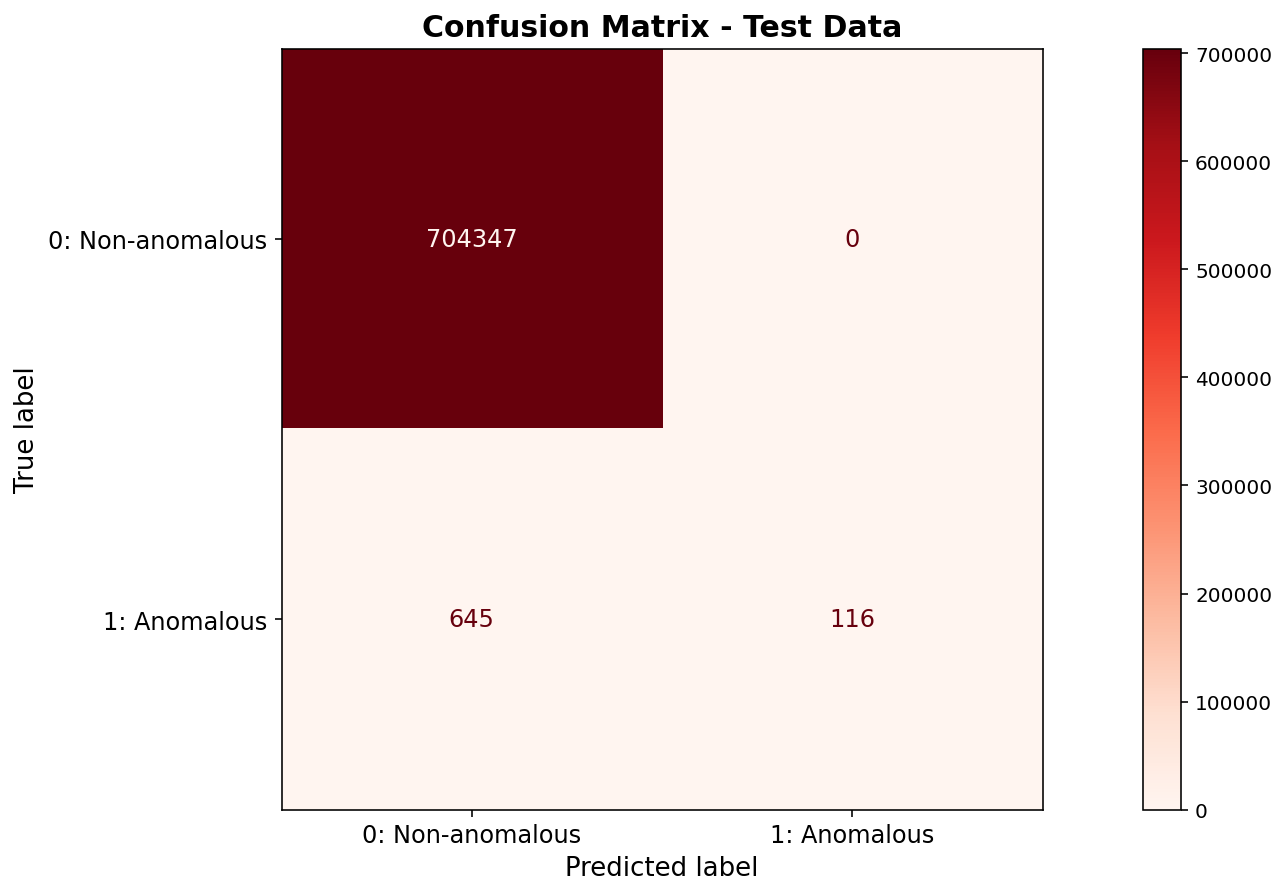

In [57]:
# Plot model confusion matrix
plot_confusion_matrix(svc_2_model, test_df_numeric)

**Remarks:**
- We're still stuck with the same 0.265 F-1 score on the testing. This is proving difficult to beat. Let's move on to a new classifier.

<br>

# Model 3.1: **Naive Bayes Classifier** with Adjusted Weights

For our next model, we'll move on to a naive Bayes classifier. There are not too many hyperparameters to tune, so we'll only adjsut the model type between (multinomial and gaussian). We'll also try reducing the weight of the negative class even further, to 0.01.

In [58]:
train_df_numeric = set_weight_col(train_df_numeric, label_col='Anomalous', neg_class_weight=0.01)

# Preview Weight column
cols_to_show = ['Anomalous', 'Weight']
train_df_numeric.select(cols_to_show).where(train_df_numeric.Anomalous == 0).show(1, truncate=False, vertical=True)
train_df_numeric.select(cols_to_show).where(train_df_numeric.Anomalous == 1).show(1, truncate=False, vertical=True)

-RECORD 0---------
 Anomalous | 0    
 Weight    | 0.01 
only showing top 1 row

-RECORD 0--------
 Anomalous | 1   
 Weight    | 1.0 
only showing top 1 row



In [59]:
nb_1 = NaiveBayes(
    featuresCol='scaled_features',
    labelCol='Anomalous',
    weightCol='Weight')

nb_1_stages = stages + [nb_1]

# Specify parameter grid
nb_1_grid = ParamGridBuilder()\
            .addGrid(nb_1.modelType, ['multinomial', 'gaussian'])\
            .build()

In [60]:
# Run grid search using grid_search function
if not os.path.isdir(drive_path + 'nb_1_model'):
    nb_1_model = grid_search(stages_with_classifier=nb_1_stages, 
                             train_df=train_df_numeric, 
                             model_grid=nb_1_grid, 
                             parallelism=2)

In [61]:
# Save model, or upload if already saved
if not os.path.isdir(drive_path + 'nb_1_model'):
    nb_1_model.save(drive_path + 'nb_1_model')
else:
    nb_1_model = TrainValidationSplitModel.load(drive_path + 'nb_1_model')
    print(nb_1_grid[np.argmax(nb_1_model.validationMetrics)])

{Param(parent='NaiveBayes_17d65b665d7c', name='modelType', doc='The model type which is a string (case-sensitive). Supported options: multinomial (default), bernoulli and gaussian.'): 'gaussian'}


In [62]:
# Print model scores
score_model(nb_1_model, train_df_numeric, test_df_numeric)

NaiveBayesModel
--------------- 

Training data:

                  precision    recall  f1-score   support

0: Non-anomalous      0.999     0.986     0.993   4686825
    1: Anomalous      0.016     0.222     0.031      4900

        accuracy                          0.985   4691725
       macro avg      0.508     0.604     0.512   4691725
    weighted avg      0.998     0.985     0.992   4691725

------------------------------------------------------------ 

Testing data:

                  precision    recall  f1-score   support

0: Non-anomalous      0.999     0.986     0.993    704347
    1: Anomalous      0.014     0.180     0.026       761

        accuracy                          0.985    705108
       macro avg      0.506     0.583     0.509    705108
    weighted avg      0.998     0.985     0.992    705108



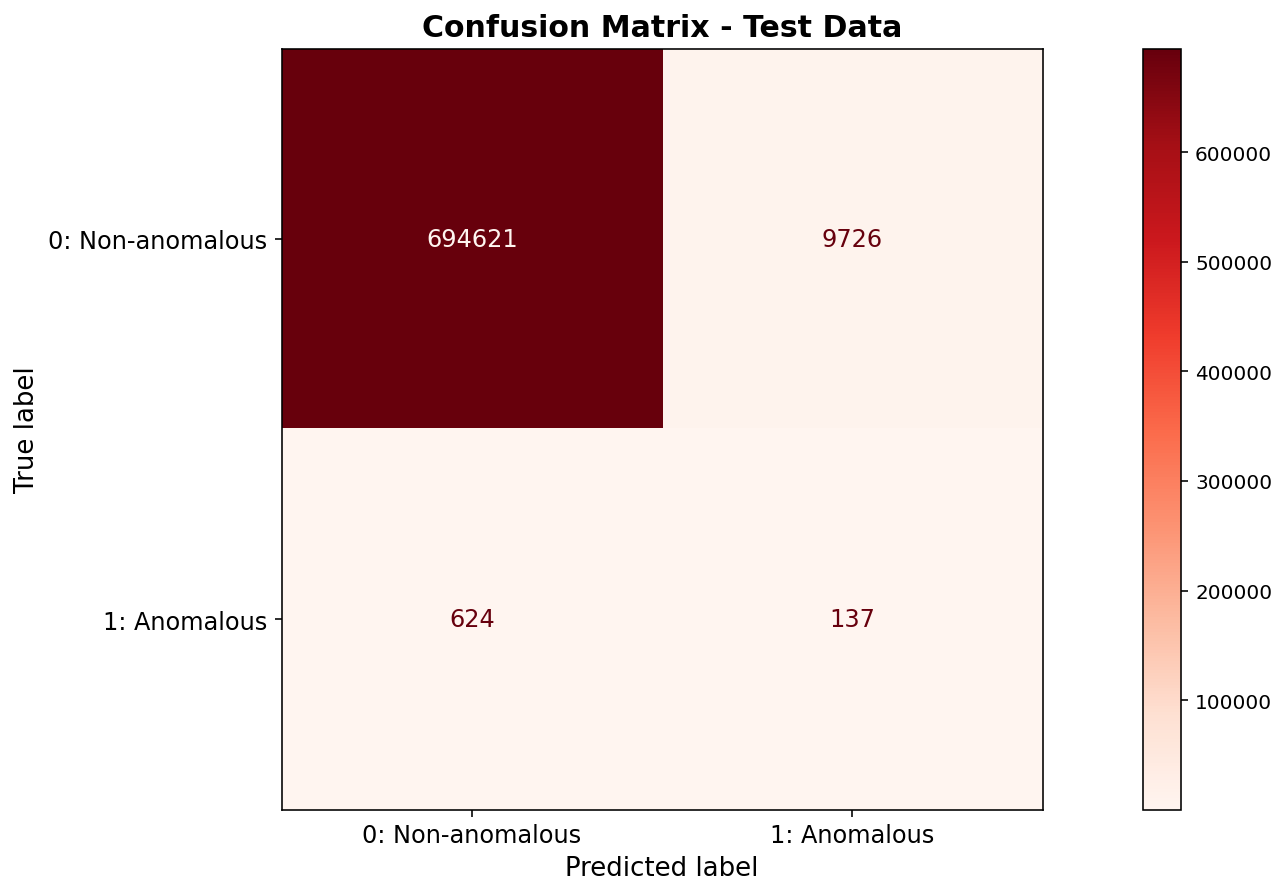

In [63]:
# Plot model confusion matrix
plot_confusion_matrix(nb_1_model, test_df_numeric)

**Remarks:**
- Well the F1-score dropped quite a bit, likely from reducing the class weights of the negatie class as much as we did. But it sure is nice to see something new for a change. We didn't get much improvement in recall for all those false positives though, improving from .152 to 0.180. Let's move on to a decision tree classifier.

<br>

# Model 4.1: **Decision Tree Classifier** with Tuned Max Depth

For our decision tree model, we'll raise the negative class weight a bit, but not too much, to 0.1. Hopefully we can raise the recall score on anomalous transactions without getting too many false positives like we did with the naive Bayes classifier.

We'll grid search over the maximum depth of the decision tree. Given the nature of decision trees to be able to pick up non-linear relationships in data, which is something the previous three classifiers are not particularly good at, hopefully we'll be able to raise our F1-score above the .265 score we've been stuck on.

In [64]:
train_df_numeric = set_weight_col(train_df_numeric, label_col='Anomalous', neg_class_weight=0.1)

# Preview Weight column
cols_to_show = ['Anomalous', 'Weight']
train_df_numeric.select(cols_to_show).where(train_df_numeric.Anomalous == 0).show(1, truncate=False, vertical=True)
train_df_numeric.select(cols_to_show).where(train_df_numeric.Anomalous == 1).show(1, truncate=False, vertical=True)

-RECORD 0--------
 Anomalous | 0   
 Weight    | 0.1 
only showing top 1 row

-RECORD 0--------
 Anomalous | 1   
 Weight    | 1.0 
only showing top 1 row



In [65]:
dt_1 = DecisionTreeClassifier(
    featuresCol='scaled_features',
    labelCol='Anomalous',
    weightCol='Weight')

dt_1_stages = stages + [dt_1]

# Specify parameter grid
dt_1_grid = ParamGridBuilder()\
            .addGrid(dt_1.maxDepth, [4, 5, 6])\
            .build()

In [66]:
# Run grid search using grid_search function
if not os.path.isdir(drive_path + 'dt_1_model'):
    dt_1_model = grid_search(stages_with_classifier=dt_1_stages, 
                             train_df=train_df_numeric, 
                             model_grid=dt_1_grid, 
                             parallelism=3)

In [67]:
# Save model, or upload if already saved
if not os.path.isdir(drive_path + 'dt_1_model'):
    dt_1_model.save(drive_path + 'dt_1_model')
else:
    dt_1_model = TrainValidationSplitModel.load(drive_path + 'dt_1_model')
    print(dt_1_grid[np.argmax(dt_1_model.validationMetrics)])

{Param(parent='DecisionTreeClassifier_a95f3df0a46b', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 4}


In [68]:
# Print model scores
score_model(dt_1_model, train_df_numeric, test_df_numeric)

DecisionTreeClassificationModel
------------------------------- 

Training data:

                  precision    recall  f1-score   support

0: Non-anomalous      0.999     1.000     1.000   4686825
    1: Anomalous      1.000     0.406     0.577      4900

        accuracy                          0.999   4691725
       macro avg      1.000     0.703     0.788   4691725
    weighted avg      0.999     0.999     0.999   4691725

------------------------------------------------------------ 

Testing data:

                  precision    recall  f1-score   support

0: Non-anomalous      0.999     1.000     1.000    704347
    1: Anomalous      1.000     0.384     0.555       761

        accuracy                          0.999    705108
       macro avg      1.000     0.692     0.777    705108
    weighted avg      0.999     0.999     0.999    705108



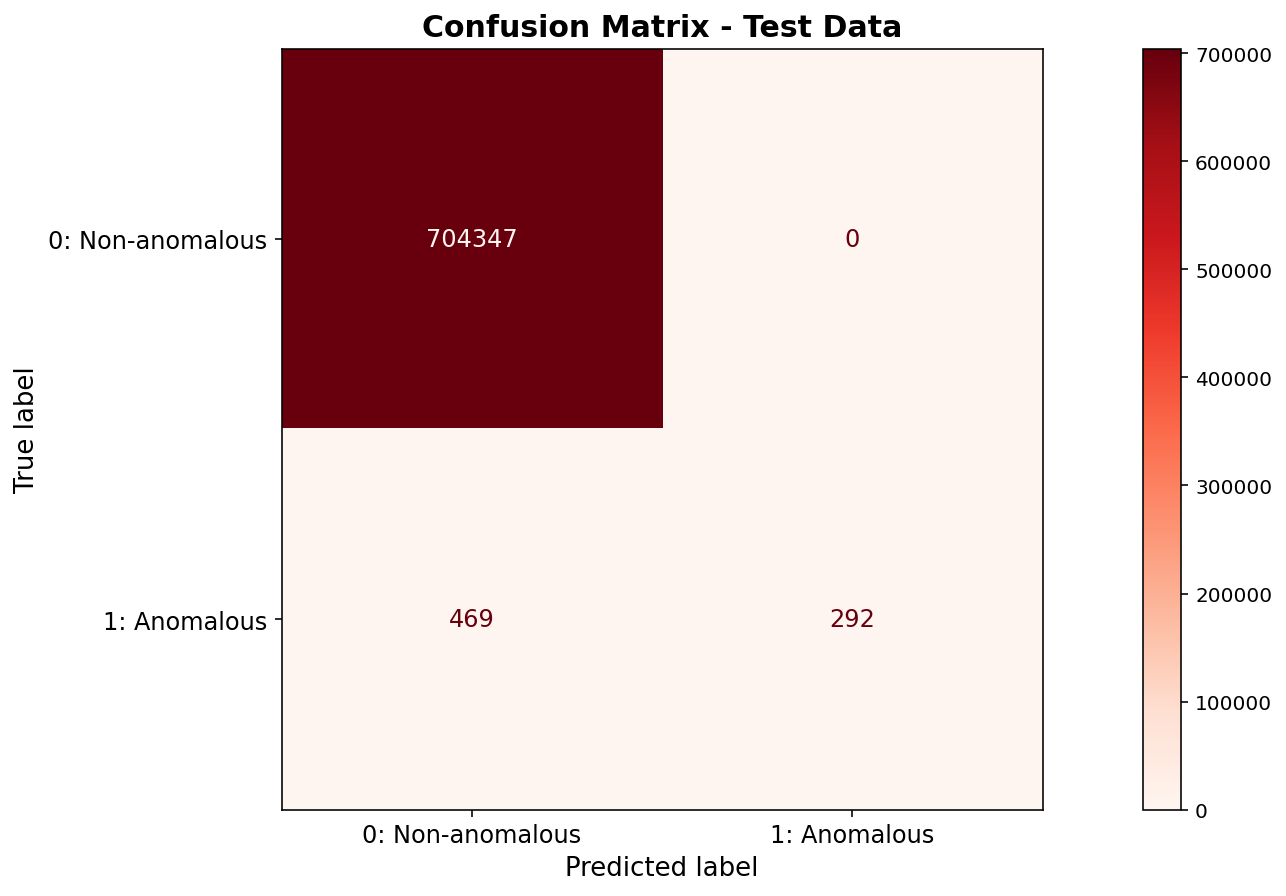

In [69]:
# Plot model confusion matrix
plot_confusion_matrix(dt_1_model, test_df_numeric)

**Remarks:**
- Now that's what we've been looking for! We've still got perfect precision with anomalous transactions, but our recall improved from 0.152 to 0.384, giving us a big boost in our F1-score to a new high of 0.555 on the testing data. We're classifying correctly 292 out of 761 anomalous transactions correctly now.
- There's more tuning we could try with the decision tree classifier, but let's move on to decision-tree based ensemble methods: gradient-boosted tree and random forest classifiers.

<br>

# Model 5.1: **Gradient-Boosted Trees Classifier** with Tuned Max Depth and Feature Subset Strategy

For our GBT classifier, we'll keep the 0.1 negative class weight that we used in the previous model. For hyperparameter tuning, we'll try to optimize the maximum depth again, and also the feature subset strategy which is the number of features to consider for splits at each tree node.

In [74]:
gbt_1 = GBTClassifier(
    featuresCol='scaled_features',
    labelCol='Anomalous',
    weightCol='Weight')

gbt_1_stages = stages + [gbt_1]

# Specify parameter grid
gbt_1_grid = ParamGridBuilder()\
            .addGrid(gbt_1.maxDepth, [3, 4, 5])\
            .addGrid(gbt_1.featureSubsetStrategy, ['auto', '0.5', '0.75'])\
            .build()

In [75]:
# Run grid search using grid_search function
if not os.path.isdir(drive_path + 'gbt_1_model'):
    gbt_1_model = grid_search(stages_with_classifier=gbt_1_stages, 
                             train_df=train_df_numeric, 
                             model_grid=gbt_1_grid, 
                             parallelism=5)

In [76]:
# Save model, or upload if already saved
if not os.path.isdir(drive_path + 'gbt_1_model'):
    gbt_1_model.save(drive_path + 'gbt_1_model')
else:
    gbt_1_model = TrainValidationSplitModel.load(drive_path + 'gbt_1_model')
    print(gbt_1_grid[np.argmax(gbt_1_model.validationMetrics)])

{Param(parent='GBTClassifier_9ffe08b2d5cc', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 5, Param(parent='GBTClassifier_9ffe08b2d5cc', name='featureSubsetStrategy', doc="The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 'n' (when n is in the range (0, 1.0], use n * number of features. When n is in the range (1, number of features), use n features). default = 'auto'"): 'auto'}


In [77]:
# Print model scores
score_model(gbt_1_model, train_df_numeric, test_df_numeric)

GBTClassificationModel
---------------------- 

Training data:

                  precision    recall  f1-score   support

0: Non-anomalous      1.000     1.000     1.000   4686825
    1: Anomalous      0.796     0.581     0.671      4900

        accuracy                          0.999   4691725
       macro avg      0.898     0.790     0.836   4691725
    weighted avg      0.999     0.999     0.999   4691725

------------------------------------------------------------ 

Testing data:

                  precision    recall  f1-score   support

0: Non-anomalous      0.999     0.939     0.968    704347
    1: Anomalous      0.010     0.562     0.019       761

        accuracy                          0.939    705108
       macro avg      0.505     0.751     0.494    705108
    weighted avg      0.998     0.939     0.967    705108



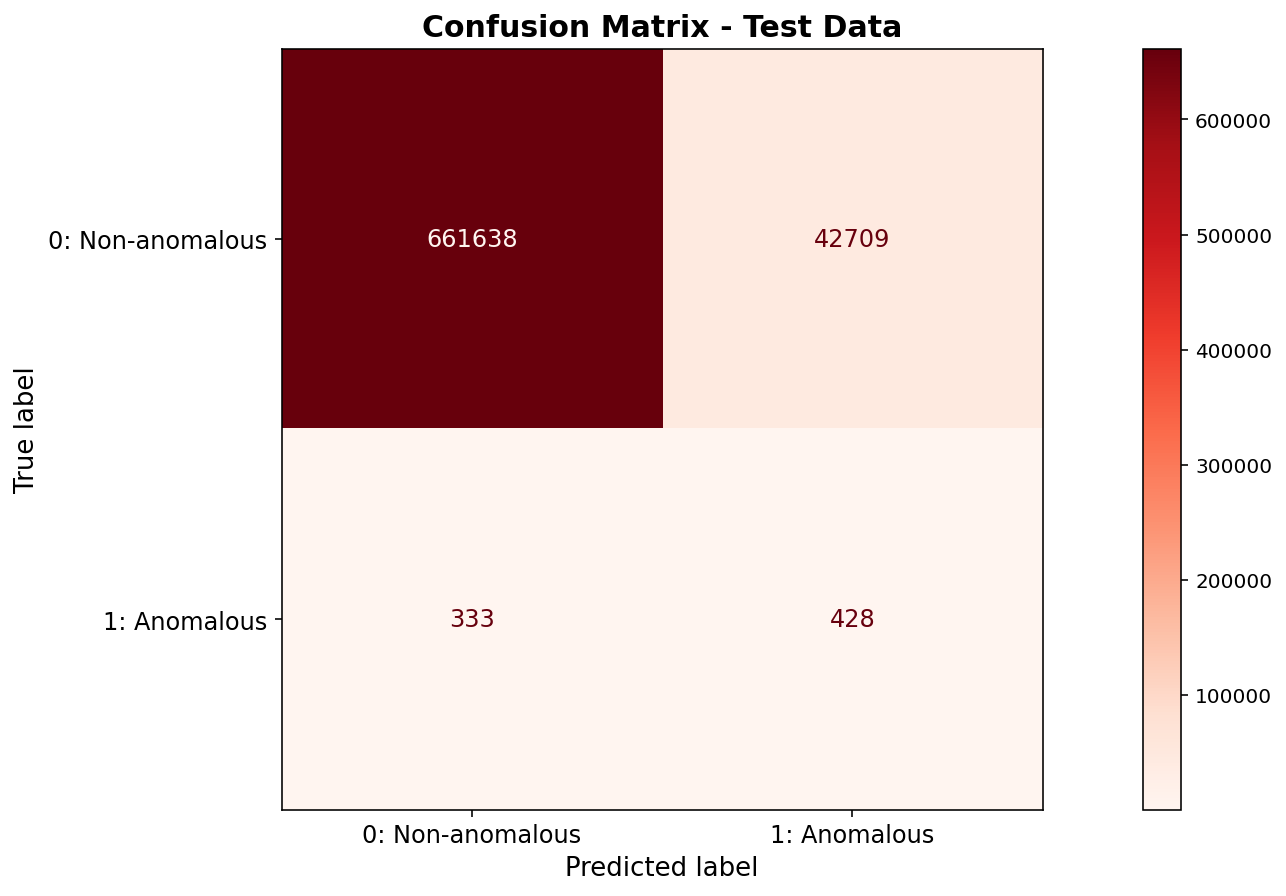

In [78]:
# Plot model confusion matrix
plot_confusion_matrix(gbt_1_model, test_df_numeric)

**Remarks:**
- Our recall improved on the testing data to 0.562, which is the highest achieved so far, but at a very high price in terms of reduced precision. Our F1-score dropped to an abysmal 0.019 because of the 0.01 precision score.
- Let's try the GBT classifier once more, but with unweighted data this time.

<br>

# Model 5.2: **Gradient Boosted Trees Classifier** with Unweighted Data

In [79]:
train_df_numeric = set_weight_col(train_df_numeric, label_col='Anomalous', neg_class_weight=1.0)

# Preview Weight column
cols_to_show = ['Anomalous', 'Weight']
train_df_numeric.select(cols_to_show).where(train_df_numeric.Anomalous == 0).show(1, truncate=False, vertical=True)
train_df_numeric.select(cols_to_show).where(train_df_numeric.Anomalous == 1).show(1, truncate=False, vertical=True)

-RECORD 0--------
 Anomalous | 0   
 Weight    | 1.0 
only showing top 1 row

-RECORD 0--------
 Anomalous | 1   
 Weight    | 1.0 
only showing top 1 row



In [80]:
gbt_2 = GBTClassifier(
    featuresCol='scaled_features',
    labelCol='Anomalous',
    weightCol='Weight')

gbt_2_stages = stages + [gbt_2]

# Specify parameter grid
gbt_2_grid = ParamGridBuilder()\
            .addGrid(gbt_2.maxDepth, [3, 4, 5])\
            .build()

In [83]:
# Run grid search using grid_search function
if not os.path.isdir(drive_path + 'gbt_2_model'):
    gbt_2_model = grid_search(stages_with_classifier=gbt_2_stages, 
                             train_df=train_df_numeric, 
                             model_grid=gbt_2_grid, 
                             parallelism=3)

In [84]:
# Save model, or upload if already saved
if not os.path.isdir(drive_path + 'gbt_2_model'):
    gbt_2_model.save(drive_path + 'gbt_2_model')
else:
    gbt_2_model = TrainValidationSplitModel.load(drive_path + 'gbt_2_model')
    print(gbt_2_grid[np.argmax(gbt_2_model.validationMetrics)])

{Param(parent='GBTClassifier_c5512ddd292f', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 3}


In [85]:
# Print model scores
score_model(gbt_2_model, train_df_numeric, test_df_numeric)

GBTClassificationModel
---------------------- 

Training data:

                  precision    recall  f1-score   support

0: Non-anomalous      0.999     1.000     1.000   4686825
    1: Anomalous      1.000     0.347     0.515      4900

        accuracy                          0.999   4691725
       macro avg      1.000     0.673     0.757   4691725
    weighted avg      0.999     0.999     0.999   4691725

------------------------------------------------------------ 

Testing data:

                  precision    recall  f1-score   support

0: Non-anomalous      0.999     0.956     0.977    704347
    1: Anomalous      0.008     0.321     0.015       761

        accuracy                          0.955    705108
       macro avg      0.503     0.638     0.496    705108
    weighted avg      0.998     0.955     0.976    705108



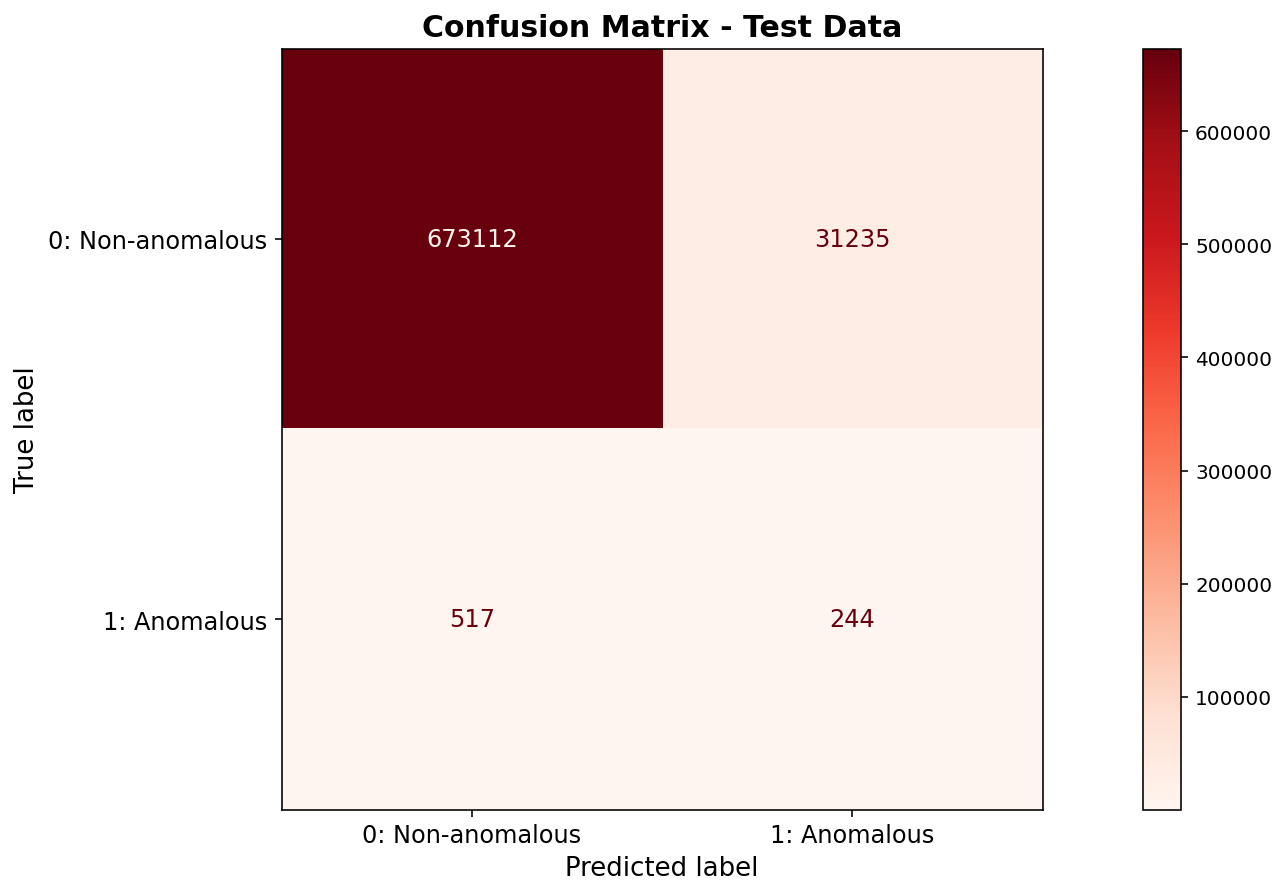

In [86]:
# Plot model confusion matrix
plot_confusion_matrix(gbt_2_model, test_df_numeric)

**Remarks:**
- Removing the weights from the dataset was not helpful. Let's move on to notebook 2, where we use the full dataset with all (relevant) categorical features.